<!--NAVIGATION-->
< [Scikit-Learn简介](05.02-Introducing-Scikit-Learn.ipynb) | [目录](Index.ipynb) | [特征工程](05.04-Feature-Engineering.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Hyperparameters and Model Validation

# 超參數和模型驗證

上一節中，我們學習了應用有監督機器學習模型的基本配方：
1. 選擇一個模型類別 Choose a class of model
2. 選擇模型超參數 Choose model hyperparameters
3. 將模型擬合到訓練數據上 Fit the model to the training data
4. 將模型在新數據上進行預測 Use the model to predict labels for new data

> The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively.In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

前兩步選擇模型類別和超參數，也許是有效使用這些工具和技術的最關鍵部分。為了作出一個明智的選擇，我們需要一個方式來*驗證*我們的模型和超參數，看它們是否擬合數據集。雖然這個方式聽起來很簡單，但是裡面有很多坑你需要避開。

## Thinking about Model Validation

### Model validation the wrong way

### 錯誤的模型驗證

> Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:
In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

原則上，模型驗證非常簡單：選擇了模型類別和它的超參數之後，我們將它應用到一些訓練數據上進行訓練，然後將它的預測值和已知值進行比較。
讓我們展示使用鳶尾花數據集來進行模型驗證的一個原始方法，首先導入數據：

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

> Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

下面我們選擇模型和超參數。這裡我們會使用*k近鄰*分類器，超參數`n_neighbors=1`。這是一個非常簡單和直觀的模型，它認為“未知的點的標籤與距離它最近的訓練點的標籤是一樣的”。

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

> Then we train the model, and use it to predict labels for data we already know: 

然後我們訓練模型，用訓練好的模型來預測訓練集的標籤：

In [3]:
model.fit(X, y)
y_model = model.predict(X)

> We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! As you may have gathered, the answer is no.In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

我們看到準確率是1.0，這表示100%的點都被我們的模型正確標記了。你直覺上應該就能知道答案是否定的。這是個最基本的錯誤：*使用同樣的數據集來訓練和評估性能*，它永遠都會是 100% 的準確率。

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

### Model validation the right way: Holdout sets

### 模型驗證的正確方式：保留部分數據

> So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

那麼應該怎麼做？將一部分數據集*保留*出來不參與訓練，並使用它們對模型的性能進行評估才是正確的辦法：意思就是我們將數據中的部分子集從訓練集中分離出來，然後再將它們預測的結果和預先標記的結果進行對比得到模型性能。這可以通過Scikit-Learn的`train_test_split`工具完成：

> We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

這樣我們就得到了一個更加合理的結果：最近鄰分類器在這樣劃分了訓練集和測試集後，能得到大約90%的準確率。這裡保留出的子數據集類似未知的數據，因為模型根本沒有*見過*它們。

In [5]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5) # 按照50%分成訓練集和測試集
model.fit(X1, y1) # 使用訓練集對模型進行擬合

# 使用模型對測試集進行預測，並評估結果
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

> cross-validation：One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.In the above case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems – especially if the initial set of training data is small. One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set. Visually, it might look something like this:

使用交叉驗證：上面的保留子數據集來驗證模型的方式有一個缺點，那就是我們其中一部分的數據無法參與模型訓練過程。在上面例子中，一半的數據集對於訓練模型沒有任何貢獻。這不是最優化的方式，而且可能導致問題，特別是原始訓練數據規模比較小的情況下。解決這個缺點的方法是使用*交叉驗證*；也就是使用一系列的擬合過程，其中每次擬合的時候都是用完整的數據集，但是不同的訓練集和測試集來進行驗證。下面描繪了這個過程：

![](figures/05.03-2-fold-CV.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#2-Fold-Cross-Validation)

> Here we do two validation trials, alternately using each half of the data as a holdout set. Using the split data from before, we could implement it like this: What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

這裡我們使用兩次驗證過程，每次使用不同的一半數據作為保留的數據集來驗證模型。使用上面分好的數據，我們使用下面的代碼實現：上面輸出了兩個準確率結果，我們可以組合（例如通過取平均值）來獲得更好的全局性能結果。上面這個特殊的交叉驗證過程被稱為*雙重檢查驗證*，也就是我們將數據均分為兩個子數據集，然後依次使用它們作為測試集。

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

> We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation: Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

我們可以將這個方法擴展到更多的擬合過程，將數據劃分為更多子集進行更多重訓練驗證，例如下圖是一個五重交叉驗證： 這裡我們將數據分成5組，每次使用其中一組來評估模型，其餘的4/5用來訓練模型。每次都要手動完成這項工作是很無聊的，因此我們可以使用Scikit-Learn的`cross_val_score`工具來直接完成它：

![](figures/05.03-5-fold-CV.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#5-Fold-Cross-Validation)

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

> Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

Scikit-Learn實現了許多有用的交叉驗證方案，它們適合於特定的場景；這些方案都是在`model_selection`模塊中實現的。例如，我們可能希望採用一種極端的方案，該方案中數據的分組等於數據的樣本數：也就是說，我們使用除了一個數據點外的其他所有數據進行訓練。這種交叉驗證被成為*leave-one-out*交叉驗證，如下例：

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

> Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction. Taking the mean of these gives an estimate of the error rate: Other cross-validation schemes can be used similarly. For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

因為我們有150個樣本，leave-one-out交叉驗證會得到150個驗證結果，結果只有兩種狀態：驗證成功（1.0）或驗證失敗（0.0）。對上面的結果數組求平均值能得到一個估計的準確率：其他交叉驗證方案也是類似的使用。想要查閱Scikit-Learn中可用的交叉驗證方案，可以使用IPython來瀏覽`sklean.model_selection`模塊或者瀏覽Scikit-Learn在線[交叉驗證文檔](http://scikit-learn.org/stable/modules/cross_validation.html)。

In [9]:
scores.mean()

0.96

## Selecting the Best Model

核心問題是：*我們的評估器是否表現不佳？我們應該如何繼續改進？ 這可能有如下的答案：

- 使用一個更加複雜或更加靈活的模型
- 使用一個沒那麼複雜或沒那麼靈活的模型
- 收集更多的訓練樣本
- 對每個樣本收集更多信息，增加特徵

> The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

對這個問題的解答經常是反直覺的。比方說有時使用一個更複雜的模型可能會得到一個更差的結果，而增加樣本數量不能改進你的結果。決定採用哪些方法步驟來改進模型的能力是成功的機器學習實踐者和不成功的實踐者之間的主要區別。

### The Bias-variance trade-off

### 偏差方差的權衡

> Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*. Consider the following figure, which presents two regression fits to the same dataset:

“最佳模型”問題根本上是關於尋找*偏差*和*方差*的最佳均衡點。考慮下圖，這是對同一個數據集的兩個回歸：

In [24]:
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

![](figures/05.03-bias-variance.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff)

> The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well. Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

左邊的模型試圖找出一條直線來擬合數據。因為這個數據很明顯比直線要復雜的多，因此直線模型不可能很好的描述這個數據集。這樣的模型我們稱為“欠擬合 (underfit)”：也就是說，它沒有提供足夠的模型靈活性來反映出數據的所有特徵；用另一種說法就是這個模型有著高的*偏差(bias)*。

> The model on the right attempts to fit a high-order polynomial through the data. Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

右邊的模型使用多項式來擬合數據。雖然它很精確的描述了訓練數據，但是這種精確性更多反映了對數據噪聲特徵而不是主要特徵的反映。這樣的模型被稱為是“過擬合(overfit)”：也就是說它有著很好的模型靈活性，甚至反映了數據的隨機誤差；另一種說法就是這個模型有著高的*方差(variance)*。

> It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

很明顯這兩個模型都不是擬合數據的最佳模型，但是它們失敗的地方是不一樣的。從另一個角度來看，如果我們使用這兩個模型來預測一些新數據的y值的話，下圖中的紅色的點代表這數據中從訓練集中分出來的數據點：

![](figures/05.03-bias-variance-2.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff-Metrics)

> The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

這裡使用的評估標準是$R^2$分值，或者稱為[決定係數](https://en.wikipedia.org/wiki/Coefficient_of_determination)，計算的是相對目標值的簡單平均值差距，用來衡量模型預測性能的好方法。 $R^2=1$代表完全複合，$R^2=0$代表模型與簡單取數據平均值沒有區別，負數值代表模型的表現還不如簡單取平均值。從兩個模型的這個分值中，我們可以得到更普遍的結論：

- 對於高偏差的模型來說，模型的性能在測試集上與在訓練集上類似。
- 對於高方差的模型來說，模型的性能在測試集上比在訓練集上差了非常多。

> If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

如果想像我們有某種能力能夠調節模型的複雜度，我們可以繪製下面的圖形代表著訓練分數和測試分數的情況：這幅圖像被稱為*驗證曲線*，我們觀察到下面這些關鍵特徵：


- 訓練分數在任何地方都比驗證分數要高。這基於：模型在它見過的數據上會比它沒見過的數據上更加擬合。
- 對於低複雜度模型（高偏差模型）來說，訓練數據是欠擬合的，這代表著模型既不能很好的預測訓練數據也不能很好的預測未知數據。
- 對於非常高複雜度模型（高方法模型）來說，訓練數據是過擬合的，這代表著模型能非常好的預測訓練數據，但是不能很好的預測未知數據。
- 對於中間部分來說，驗證曲線有一個最大值。這個點代表著偏差和方差的最佳平衡點。

![](figures/05.03-validation-curve.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Validation-Curve)

### Validation curves in Scikit-Learn

### Scikit-Learn中的验证曲线

> Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

下面我們來看一個例子說明使用交叉驗證來計算一種模型的驗證曲線。這裡我們將使用*多項式回歸*模型：這是一個廣義的線性模型，其中的多項式的階是可調整的參數。例如，一階的多項式將數據擬合到一條直線上；模型參數有$a$和$b$：

$$
y = ax + b
$$

> A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

一個三階的多項式將數據是配到一條三次方程曲線上；模型參數有$a, b, c, d$：

$$
y = ax^3 + bx^2 + cx + d
$$

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

> Now let's create some data to which we will fit our model:

現在我們讓我們創建一些數據來擬合模型：

In [29]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # 随机数据取样生成
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

> We can now visualize our data, along with polynomial fits of several degrees:

然後對數據進行可視化，包含著不同階的多項式匹配結果：

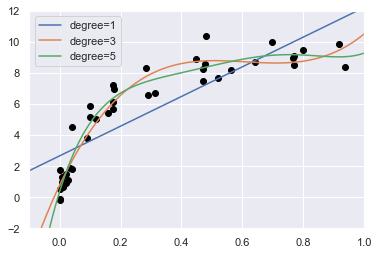

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # 用Seaborn可视化

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

> The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

這個例子中控制模型複雜度的開關就是多項式的階數，可以使任何非負的整數。這里關鍵的問題是：哪個階的多項式在偏差（欠擬合）和方差（過擬合）之間達到了合適的平衡？

> We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

我們還可以進一步將這個特殊的數據和模型的驗證曲線繪製出來；這可以直接通過Scikit-Learn提供的`validation_curve`工具完成。給定模型、數據、參數名稱和一個範圍，這個函數能夠自動計算範圍內所有的訓練分數和驗證分數：

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


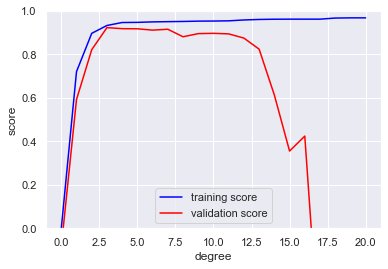

In [31]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

> This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

從驗證曲線中，我們可以看到最優的偏差和方差平衡出現在三階的多項式附近；我們可以在原始數據上計算並展示這個模型：上圖精確的展示了我們期望的定量行為：訓練分數在任何地方都高於驗證分數；訓練分數是一個單調遞增函數，隨著模型複雜度增加而增加；然而驗證分數在達到最大值後會因為過擬合而開始下降。

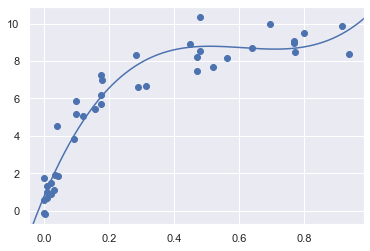

In [33]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

> Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

請注意尋找這個最優模型並不需要計算訓練分數，但是檢驗訓練分數和驗證分數之間的關係能為我們提供模型性能的內在含義。

## Learning Curves 學習曲線

> One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

對於模型複雜度來說一個重要的相關性是它依賴於訓練數據的規模。例如，我們創建一個數據集，具有5倍數量的樣本：

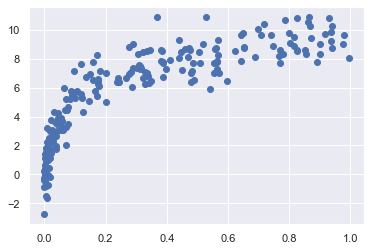

In [34]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

> We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

我們重複前面的代碼來繪製這個大的數據集的驗證曲線；為了對比我們將前面的結果也用虛線畫出來：

/Users/jerrychien/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


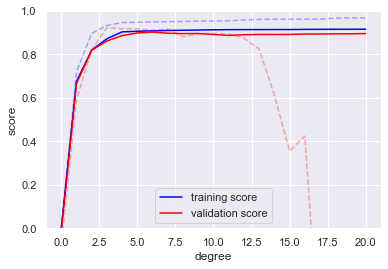

In [35]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

> The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

實線展示新的結果，而虛線展示的是前面小數據集的結果。從驗證曲線很明顯看出大的數據集能夠支持更複雜的模型：上圖中的峰值大約出現在階數6的位置上，但是甚至到了20階的多項式模型中，也沒有出現嚴重的過擬合，驗證分數和訓練分數依然很接近。

> Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

因此我們看到了驗證曲線不止有一個而是有兩個重要的輸入參數：模型複雜度和數據樣本量。研究模型的性能與樣本量之間的關係函數經常也很有幫助，我們可以通過不斷增加數據中用來訓練的子數據集規模來進行研究。繪製一幅訓練/驗證分數隨著訓練集規模變化的圖像被稱為*學習曲線*。

> The general behavior we would expect from a learning curve is this:

從學習曲線中我們一般可以觀察到下面的結論：

- 在小數據集的情況下，一個給定複雜度的模型很可能會*過擬合*：這意味著訓練分數相對來說比較高而驗證分數比較低。
- 在大數據集的情況下，一個給定複雜度的模型很可能會*欠擬合*：這意味著訓練分數會下降而驗證分數會上升。
- 一個模型應該永遠（除非很偶然的情況下）在訓練集給出比測試集更高的分值：這意味著兩根曲線會一直接近但是不會相交。

> With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

有了上述結論，我們預計的學習曲線如下圖：

![](figures/05.03-learning-curve.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Learning-Curve)

> The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

學習曲線的一個著名特徵就是當訓練樣本量增加時，兩根曲線會收斂。這意味著，一旦你已經有了足夠的樣本量使得某種模型已經收斂的話，*增加更多的訓練數據不會提供任何幫助*。在這種情況下提升模型性能的唯一方法就是使用另一個（通常更複雜）的模型。

### Learning curves in Scikit-Learn

> Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

Scikit-Learn提供了一個方便的工具來計算模型的學習曲線；下面我們計算我們原始數據集在二階多項式模型和九階多項式模型上的學習曲線：

> This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

這是一項非常有價值的分析，因為它為我們提供了模型隨著訓練數據增加發生性能變化的可視化展示。而且當你的學習曲線已經收斂時（例如當訓練和驗證曲線已經非常接近的情況下）*增加更多的訓練數據不會顯著的提升擬合度*。這個結論很容易從左圖二階模型的學習曲線中獲得。

> The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

要提升已經收斂的學習曲線的性能唯一方法就是使用一個不同的（通常更複雜的）模型。我們可以從右圖中看到：當使用了複雜的多的模型後，我們將收斂的分數值（使用虛線表示）提升了，付出的代價是更高的模型方差（圖中訓練曲線和驗證曲線的間距）。如果我們繼續增加更多的樣本，更複雜模型的學習曲線最終也會收斂。

> Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

繪製模型和數據集的學習曲線能幫助你作出進一步改善性能的決定。

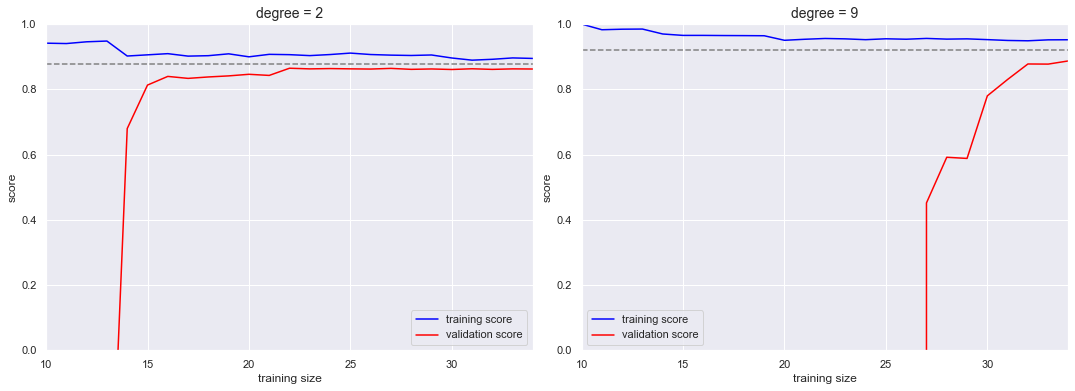

In [36]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## Validation in Practice: Grid Search

## 驗證實踐：網格搜索

> The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

前面的討論意在為你提供直觀的偏差和方差權衡的知識，它取決於模型複雜度和訓練集規模。在實踐中，模型通常有多於一個開關進行調節，因此前面關於驗證曲線和學習曲線的二維線條就會變成多維平面。在這些情況下，要將它可視化出來是很困難的，並且我們更希望簡單的找到特定模型能最大化驗證分數。

> Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

Scikit-Learn提供了自動化的工具來完成這項任務，它們在網格搜索模塊中。下面是一個使用網格搜索找到最優多項式模型的例子。我們會探索模型特徵的一個三維網格；包括多項式階數，一個是否擬合截距的標誌和一個是否歸一化問題的標誌。這可以通過Scikit-Learn的`GridSearchCV`元評估器來設置：

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

> Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

網格搜索模型和普通模型一樣，實例化後還未應用到任何數據上。通過調用`fit()`方法會將模型的每個網格點擬合到數據上，同時過程中保存了驗證的分數：

In [38]:
grid.fit(X, y);

> Now that this is fit, we can ask for the best parameters as follows:

擬合完後，我們可以使用代碼來獲得最佳參數：

In [39]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

> Finally, if we wish, we can use the best model and show the fit to our data using code from before:

最終，需要的話，我們可以使用代碼將最佳模型、數據及它們的擬合情況繪製出來：

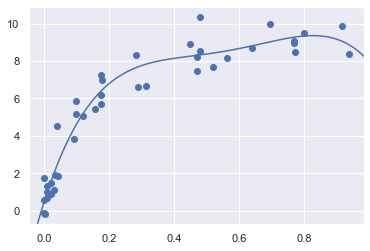

In [40]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

> The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.
For information, see the examples in [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) and [Feature Engineering: Working with Images](05.14-Image-Features.ipynb), or refer to Scikit-Learn's [grid search documentation](http://Scikit-Learn.org/stable/modules/grid_search.html).

網格搜索提供很多其他參數，包括指定自定義的評分函數，並行化計算和執行隨機搜索等等。需要更多信息，參見[深入：核密度估計](05.13-Kernel-Density-Estimation.ipynb)和[特徵工程](05.14-Image-Features.ipynb)，或者參考Scikit-Learn的[網格搜索在線文檔](http://Scikit-Learn.org/stable/modules/grid_search.html)。

## Summary

## 總結

> In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.

在本節中，我們開始探討模型驗證和超參數優化的概念，聚焦在偏差方差權衡的直觀概念和它在模型擬合數據時扮演的角色。特別是，我們強調使用測試集驗證和交叉驗證方法的重要性，當在復雜/靈活模型中調節參數時要避免過擬合。

> In later sections, we will discuss the details of particularly useful models, and throughout will talk about what tuning is available for these models and how these free parameters affect model complexity.
Keep the lessons of this section in mind as you read on and learn about these machine learning approaches!

在後續章節中，我們會討論每種模型的細節，並在過程中介紹這些模型可以調節哪些參數以及這些參數如何影響模型複雜度。請將本節的內容牢記，當你在後面繼續學習機器學習方法的時候，本節內容會提供重要的幫助。

<!--NAVIGATION-->
< [Scikit-Learn简介](05.02-Introducing-Scikit-Learn.ipynb) | [目录](Index.ipynb) | [特征工程](05.04-Feature-Engineering.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
